<a href="https://colab.research.google.com/github/wilberquito/ds-thesis/blob/main/Code/NN/MelanomaClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import requests
from pathlib import Path

In [104]:
kaggle_json_url = 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/kaggle.json'
kaggle_json = '/root/.kaggle/kaggle.json'

if Path(kaggle_json).exists():
  print('Kaggle auth already configured')
else:
  Path('/root/.kaggle').mkdir(parents=True, exist_ok=True)
  with open(kaggle_json, 'wb') as f:
    print('Configuring kaggle auth...')
    request = requests.get(kaggle_json_url)
    f.write(request.content)
    print(request.content)
    !chmod 600 ~/.kaggle/kaggle.json

Kaggle auth already configured


In [105]:
downloader_script_url = 'https://raw.githubusercontent.com/wilberquito/ds-thesis/main/Code/NN/downloader.sh'
downloader_script = 'downloader.sh'

if Path(downloader_script).exists():
  print('Already downloaded script downloader')
else:
  print('Downloading script downloader...')
  with open(downloader_script, 'wb') as f:
    request = requests.get(downloader_script_url)
    f.write(request.content)
  print('Downloading data using the downloader script...')
  !sh downloader.sh

Already downloaded script downloader


In [106]:
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

## Exploratory data analysis

In [107]:
path = Path(f'./data/jpeg-melanoma-{512}x{512}/train.csv')
df = pd.read_csv(path)
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [109]:
df.describe()

,age_approx,target,tfrecord,width,height
count,33058.000000,33126.000000,33126.000000,33126.000000,33126.000000
mean,48.870016,0.017630,6.894826,4039.630381,2678.758256
std,14.380360,0.131603,4.390486,2109.145590,1437.617626
min,0.000000,0.000000,-1.000000,640.000000,480.000000
25%,40.000000,0.000000,3.000000,1872.000000,1053.000000
50%,50.000000,0.000000,7.000000,5184.000000,3456.000000
75%,60.000000,0.000000,11.000000,6000.000000,4000.000000
max,90.000000,1.000000,14.000000,6000.000000,6000.000000


### Diagnosis

Here I notice that the are a lot of `unknown` diagnosis. 

There are also few examples of `solar lentigo`, `cafe-au-lait macule` and `atypical melanocytic proliferation`. 

In [110]:
diagnosis_freq = df['diagnosis'].value_counts()
diagnosis_freq

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

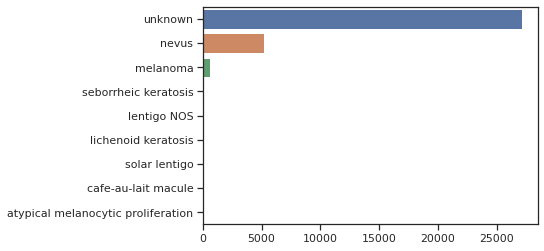

In [111]:
_ = sns.barplot(x=diagnosis_freq.values, y=diagnosis_freq.index)

### TfRecord

There are some entries that it's `tfrecord` features are labeled as -1

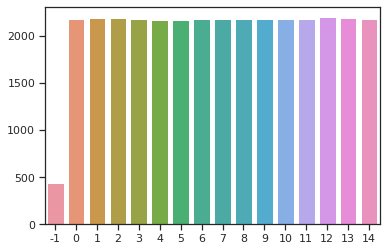

In [112]:

tfrecord_freq = df['tfrecord'].value_counts()
_ = sns.barplot(y=tfrecord_freq.values, x=tfrecord_freq.index)

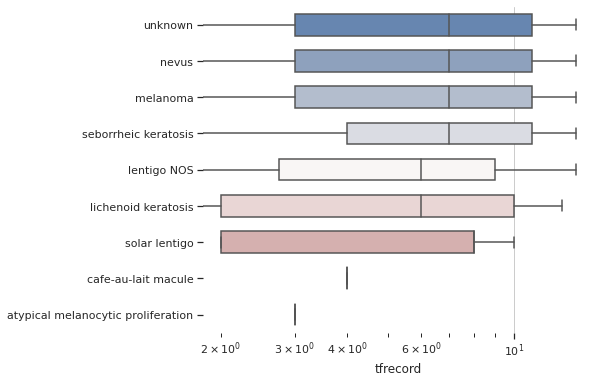

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
ax.set_xscale("log")

# Plot the orbital period with horizontal boxes
sns.boxplot(x="tfrecord", y="diagnosis", data=df,
            whis=[0, 100], width=.6, palette="vlag")

# # Add in points to show each observation
# sns.stripplot(x="distance", y="method", data=df,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="")
sns.despine(trim=True, left=True)

In [157]:
def get_meta_data(df_train, df_test):

    # One-hot encoding of anatom_site_general_challenge feature
    concat = pd.concat([df_train['anatom_site_general_challenge'], df_test['anatom_site_general_challenge']], ignore_index=True)
    dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
    df_train = pd.concat([df_train, dummies.iloc[:df_train.shape[0]]], axis=1)
    df_test = pd.concat([df_test, dummies.iloc[df_train.shape[0]:].reset_index(drop=True)], axis=1)

    # Sex features
    df_train['sex'] = df_train['sex'].map({'male': 1, 'female': 0})
    df_test['sex'] = df_test['sex'].map({'male': 1, 'female': 0})
    df_train['sex'] = df_train['sex'].fillna(-1)
    df_test['sex'] = df_test['sex'].fillna(-1)

    # Age features
    df_train['age_approx'] /= 90
    df_test['age_approx'] /= 90
    df_train['age_approx'] = df_train['age_approx'].fillna(0)
    df_test['age_approx'] = df_test['age_approx'].fillna(0)
    df_train['patient_id'] = df_train['patient_id'].fillna(0)

    # Compute the number of images that each user has
    df_train['n_images'] = df_train['patient_id'].map(df_train.groupby(['patient_id']).image_name.count())
    df_test['n_images'] = df_test['patient_id'].map(df_test.groupby(['patient_id']).image_name.count())
    df_train.loc[df_train['patient_id'] == -1, 'n_images'] = 1
    df_train['n_images'] = np.log1p(df_train['n_images'].values)
    df_test['n_images'] = np.log1p(df_test['n_images'].values)
    
    # Compute train image size
    train_images = df_train['filepath'].values
    train_sizes = np.zeros(train_images.shape[0])
    for i, img_path in enumerate(tqdm(train_images)):
      if (not Path(img_path).exists()):
        print(f"Img {img_path} doen't exist")
      else:
        train_sizes[i] = os.path.getsize(img_path)
    df_train['image_size'] = np.log(train_sizes)

    # Compute test image size
    test_images = df_test['filepath'].values
    test_sizes = np.zeros(test_images.shape[0])
    for i, img_path in enumerate(tqdm(test_images)):
      if (not Path(img_path).exists()):
        print(f"Img {img_path} doen't exist")
      else:
        test_sizes[i] = os.path.getsize(img_path)
    df_test['image_size'] = np.log(test_sizes)

    meta_features = ['sex', 'age_approx', 'n_images', 'image_size'] + [col for col in df_train.columns if col.startswith('site_')]
    n_meta_features = len(meta_features)

    return df_train, df_test, meta_features, n_meta_features


def get_df(out_dim: int, data_dir: str, data_folder: str, use_meta:bool = False):

  # 2020 data
  train_path = Path(data_dir) / Path(f'jpeg-melanoma-{data_folder}x{data_folder}/train.csv')
  df_train = pd.read_csv(train_path)
  
  # Drops samples where tfrecord is -1
  df_train = df_train[df_train['tfrecord'] >= 0].reset_index(drop=True)
  df_train['fold'] = df_train['tfrecord']
  df_train['filepath'] = df_train['image_name'].apply(lambda img : train_path.parents[0] / Path(f'train/{img}.jpg'))
  df_train['is_ext'] = 0

  # 2018 and 2019 data
  train_path = Path(data_dir) / Path(f'jpeg-isic2019-{data_folder}x{data_folder}/train.csv')
  df_train2 = pd.read_csv(train_path)
  df_train2 = df_train2[df_train2['tfrecord'] >= 0].reset_index(drop=True)
  df_train2['filepath'] = df_train2['image_name'].apply(lambda img: train_path.parents[0] / Path(f'train/{img}.jpg'))
  df_train2['is_ext'] = 1

  # Preprocess Target
  df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('seborrheic keratosis', 'BKL'))
  df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lichenoid keratosis', 'BKL'))
  df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('solar lentigo', 'BKL'))
  df_train['diagnosis']  = df_train['diagnosis'].apply(lambda x: x.replace('lentigo NOS', 'BKL'))

  # Join categorical variables to adapt to the output of the nn
  if out_dim == 8:
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
  elif out_dim == 4:
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('NV', 'nevus'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('MEL', 'melanoma'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('DF', 'unknown'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('AK', 'unknown'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('SCC', 'unknown'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('VASC', 'unknown'))
    df_train2['diagnosis'] = df_train2['diagnosis'].apply(lambda x: x.replace('BCC', 'unknown'))
  else:
    raise NotImplementedError()

  # Definition of the hole train dataframe
  df_train = pd.concat([df_train, df_train2]).reset_index(drop=True)

  # Create target column that represents the diagnostic using a number
  diagnosis2idx = {d: idx for idx, d in enumerate(sorted(df_train.diagnosis.unique()))}
  df_train['target'] = df_train['diagnosis'].map(diagnosis2idx)

  # Save which idx represent the melanoma
  mel_idx = diagnosis2idx['melanoma']

  # Test dataframe
  test_path = Path(data_dir) / Path(f'jpeg-melanoma-{data_folder}x{data_folder}/test.csv')
  df_test = pd.read_csv(test_path)
  df_test['filepath'] = df_test['image_name'].apply(lambda img : test_path.parents[0] / Path(f'test/{img}.jpg'))

  if use_meta:
    df_train, df_test, meta_features, n_meta_features = get_meta_data(df_train, df_test)
  else:
    meta_features = None
    n_meta_features = 0

  return df_train, df_test, meta_features, n_meta_features, mel_idx

In [158]:
df_train, df_test, meta_features, n_meta_features, melanoma_id = get_df(8, './data', '512', True)
df_train.head()

100%|██████████| 10982/10982 [00:00<00:00, 58263.29it/s]


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,site_lateral torso,site_lower extremity,site_oral/genital,site_palms/soles,site_posterior torso,site_torso,site_upper extremity,site_nan,n_images,image_size
0,ISIC_2637011,IP_7279968,1.0,0.500000,head/neck,unknown,benign,10,0,6000,...,0,0,0,0,0,0,0,0,4.753590,11.165139
1,ISIC_0015719,IP_3075186,0.0,0.500000,upper extremity,unknown,benign,10,0,6000,...,0,0,0,0,0,0,1,0,3.218876,11.318394
2,ISIC_0052212,IP_2842074,0.0,0.555556,lower extremity,nevus,benign,9,6,1872,...,0,1,0,0,0,0,0,0,1.791759,11.033292
3,ISIC_0068279,IP_6890425,0.0,0.500000,head/neck,unknown,benign,10,0,1872,...,0,0,0,0,0,0,0,0,3.135494,11.438105
4,ISIC_0074268,IP_8723313,0.0,0.611111,upper extremity,unknown,benign,10,11,6000,...,0,0,0,0,0,0,1,0,3.044522,11.190928


In [156]:
# You can notice that from anotom_site_general_challenge it generates onehot encoding of this categorical variable
# and generates the features that start with site_
df_train.columns

Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'tfrecord', 'width', 'height', 'fold', 'filepath', 'is_ext',
       'site_anterior torso', 'site_head/neck', 'site_lateral torso',
       'site_lower extremity', 'site_oral/genital', 'site_palms/soles',
       'site_posterior torso', 'site_torso', 'site_upper extremity',
       'site_nan', 'n_images', 'image_size'],
      dtype='object')

In [159]:
diagnosis_freq = df_train['diagnosis'].value_counts()
diagnosis_freq, len(diagnosis_freq)

(unknown                               26697
 nevus                                 18031
 melanoma                               5090
 BCC                                    3320
 BKL                                    2837
 AK                                      867
 SCC                                     628
 VASC                                    253
 DF                                      239
 cafe-au-lait macule                       1
 atypical melanocytic proliferation        1
 Name: diagnosis, dtype: int64, 11)

In [161]:
diagnosis_freq = df_train['target'].value_counts()
diagnosis_freq, len(diagnosis_freq)

(10    26697
 9     18031
 8      5090
 1      3320
 2      2837
 0       867
 4       628
 5       253
 3       239
 7         1
 6         1
 Name: target, dtype: int64, 11)

In [162]:
melanoma_id

8